In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import pytorch_lightning as pl
import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

BATCH_SIZE = 16

2.3.3
2.1.2+cpu
0.16.2+cpu


In [2]:
!pip3 install gdown
!gdown 1MppanxoA4w8RUWn3tb_rcKyoVznrCc-k
! unzip -o faces.zip

#https://drive.google.com/file/d/1MppanxoA4w8RUWn3tb_rcKyoVznrCc-k/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1MppanxoA4w8RUWn3tb_rcKyoVznrCc-k
To: /kaggle/working/faces.zip
100%|██████████████████████████████████████| 15.5M/15.5M [00:00<00:00, 57.6MB/s]
Archive:  faces.zip
   creating: CV_project1_data/
   creating: CV_project1_data/data/
   creating: CV_project1_data/data/train/
   creating: CV_project1_data/data/train/bill_gates/
  inflating: CV_project1_data/data/train/bill_gates/006f6dcf-315f-4291-80d2-b61054210273.jpg  
  inflating: CV_project1_data/data/train/bill_gates/00715f3e-b281-4199-91c7-7da7a8475d7b.jpg  
  inflating: CV_project1_data/data/train/bill_gates/00a6f308-78d3-4ebc-b441-23aebc81ddff.jpg  
  inflating: CV_project1_data/data/train/bill_gates/00b4268f-0870-486c-98b0-9d13e6834525.jpg  
  inflating: CV_project1_data/data/train/bill_gates/011e2141-db98-43a5-ba17-2dbe3a7604c0.jpg  
  inflating: CV_project1_data/data/train/bill_gates/0121cf2a-33d3-425b-aca7-6a03de5cbd1e.jpg  
  inflating: CV_project1_data/data/train/bill_gates

In [62]:
!ls CV_project1_data/data

test  train  valid


In [5]:
!find CV_project1_data/data/train -type f | wc -l
!find CV_project1_data/data/valid -type f | wc -l

3000
914


[('CV_project1_data/data/train/steve_jobs/ddaf7565-05da-46ba-aaf6-62f927e10e00.jpg',
  4),
 ('CV_project1_data/data/train/steve_jobs/ddde306c-bedd-4f19-b2b0-a563fac9b323.jpg',
  4),
 ('CV_project1_data/data/train/steve_jobs/ddffade7-febb-47c8-a9c6-85700d1afcd9.jpg',
  4)]

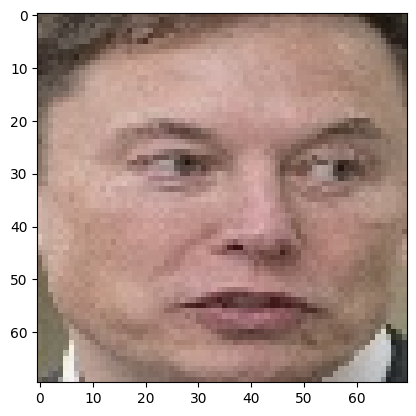

In [63]:
train = ImageFolder("CV_project1_data/data/train")
valid = ImageFolder("CV_project1_data/data/valid")

plt.imshow(train[911][0])
train.samples[-3:]

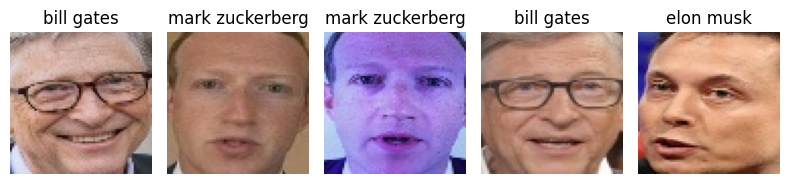

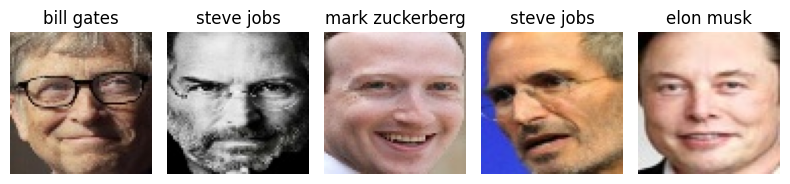

In [64]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(8, 6))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(f"{random_label.replace('_',' ')}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

plot_samples(train)
plot_samples(valid)

In [65]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train.transform = transforms.Compose([
    transforms.RandomResizedCrop(70),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid.transform = transforms.Compose([
    transforms.Resize(70),
    #transforms.CenterCrop(70),
    transforms.ToTensor(),
    normalize
])


train_loader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

In [75]:
# we'll use pretrained resnet34 as base model final fc layer replaced
net = models.resnet34(pretrained=True)
net.fc = torch.nn.Linear(512, len(train.classes))

criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

In [77]:
def train_model(net, optimizer, train_loader, valid_loader, num_epochs=10):
    """NN training
    """
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        # enable gradient count
        torch.set_grad_enabled(True)
        # training mode on
        net.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            target = target.to(device)

            # computing raw predict and loss
            output = net(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # updating weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # gradient off for validation
        torch.set_grad_enabled(False)
        # validation mode on
        net.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(valid_loader)):
            images = images.to(device)
            target = target.to(device)

            output = net(images)
            loss = criterion(output, target)
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

In [78]:
loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_loader, valid_loader, 20)

100%|██████████| 58/58 [00:00<00:00, 68.86it/s]


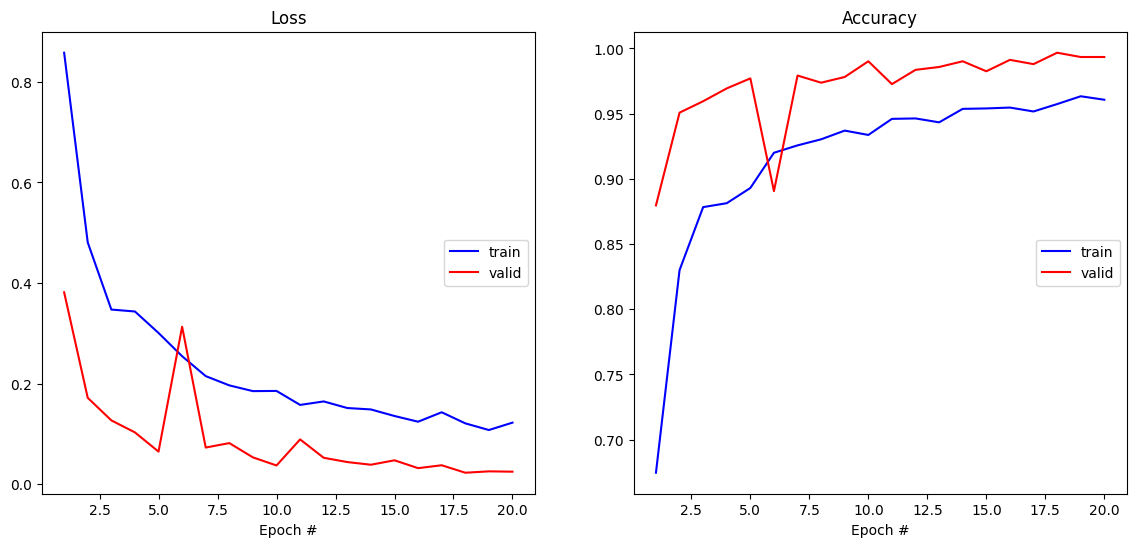

In [79]:
# visualization of the training process
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b", label='train')
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r", label='valid')
plt.legend(loc='center right')
plt.xlabel("Epoch #")
plt.title("Loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b", label='train')
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r", label='valid')
plt.legend(loc='center right')
plt.xlabel("Epoch #")
plt.title("Accuracy")

plt.show()

1) For both sample sets accuracy increases, reaches a plateau with values >90%;

2) At the same time, the difference in accuracies for training and validation sets is not large, so the model is not overfitted.

3) The validation set is characterized by a smaller value of the loss function and greater accuracy throughout the entire training. This may be explained by the small size of the “well-chosen” validation set

### Using the model for prediction

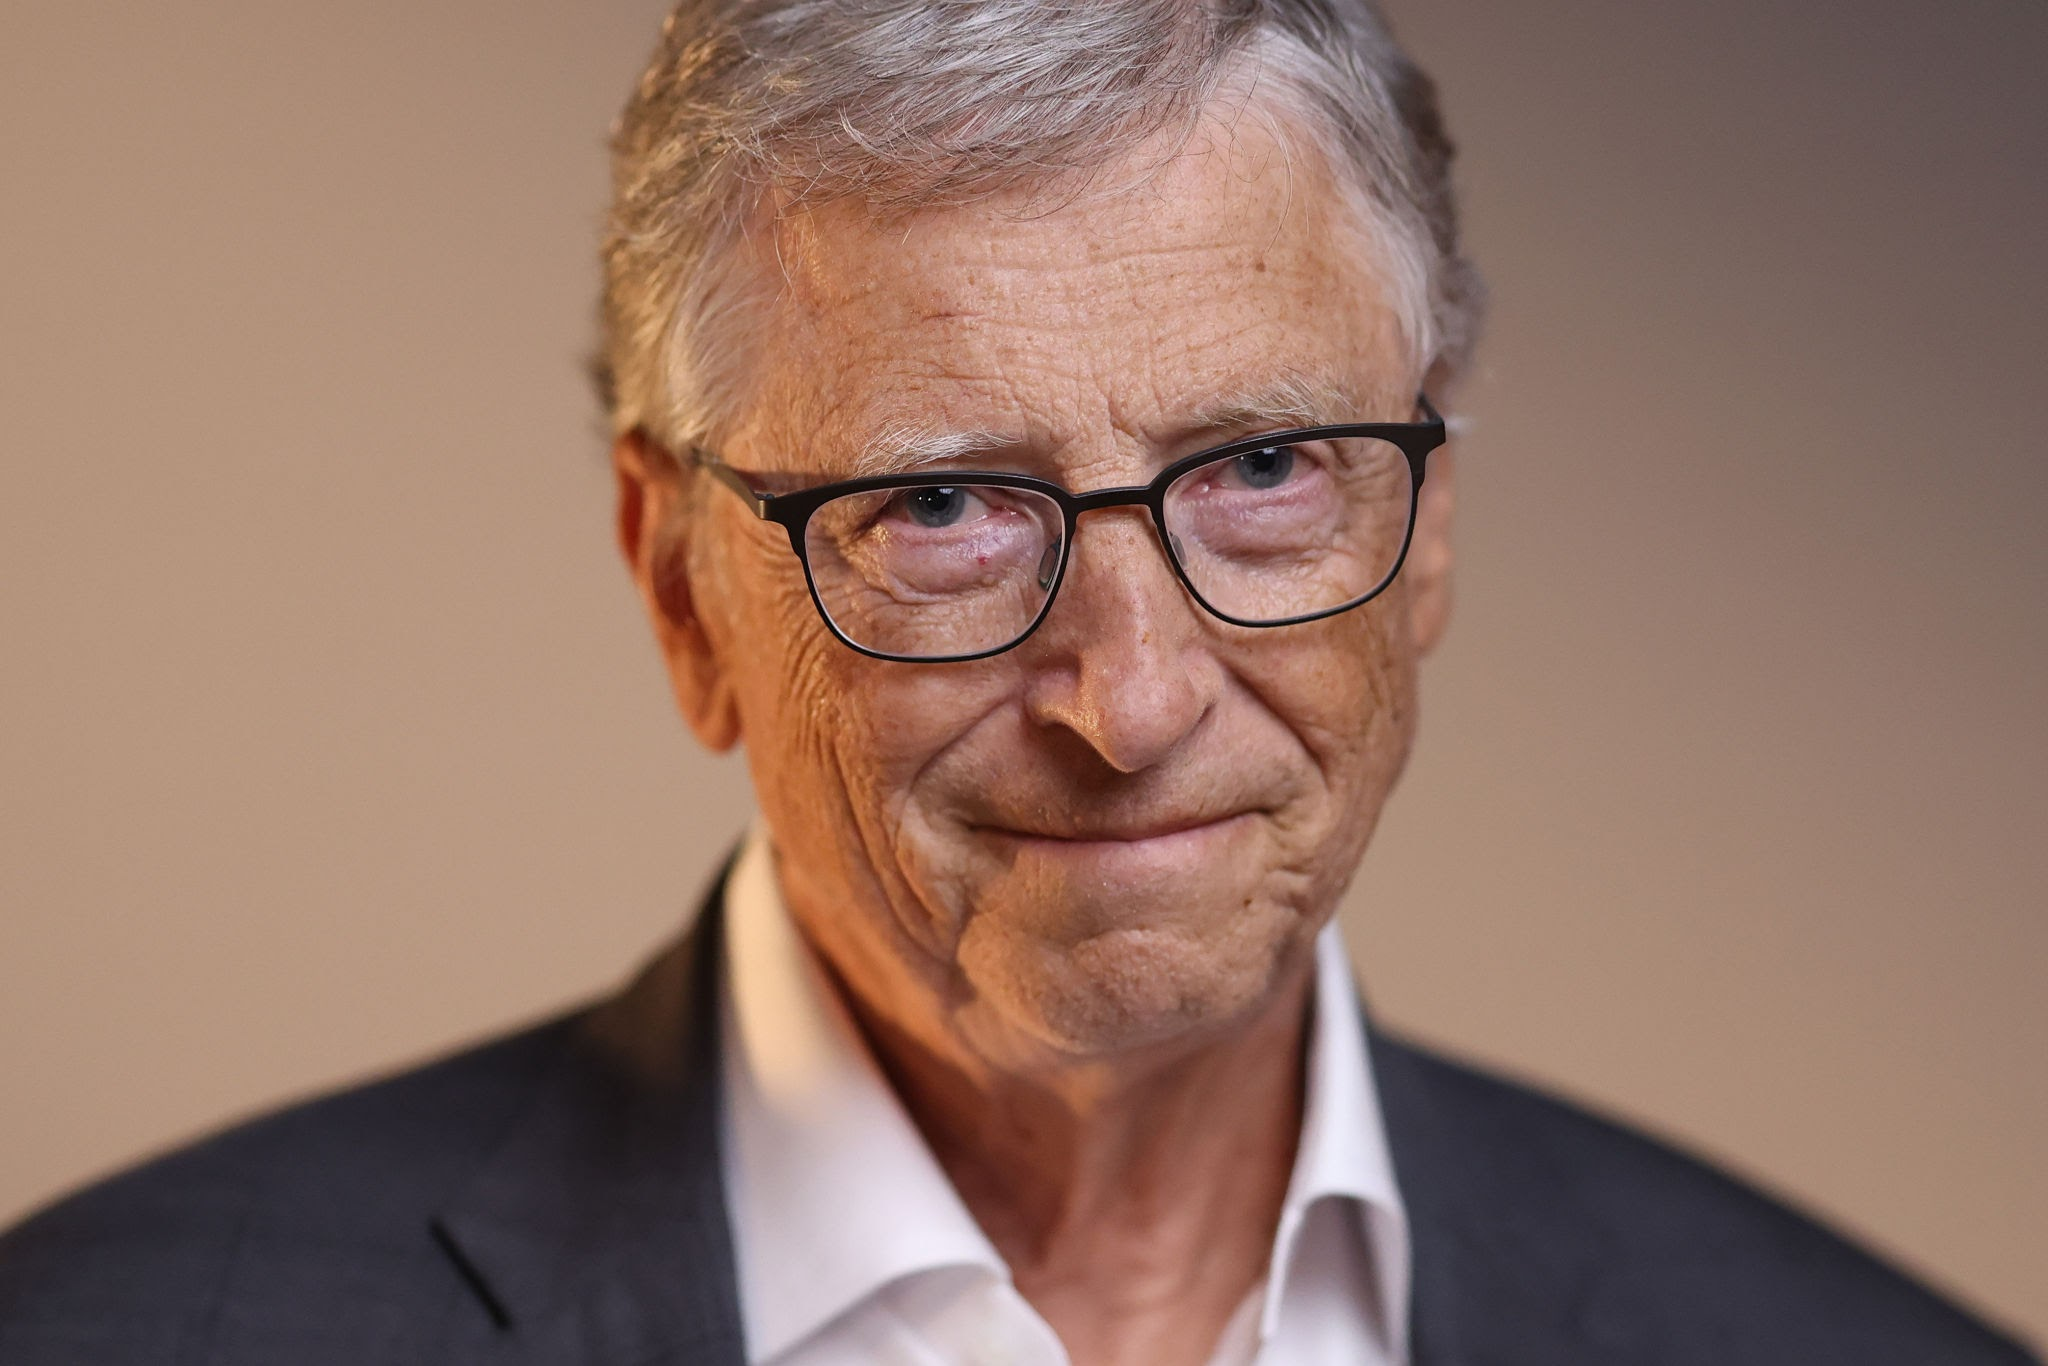

In [80]:
#i = 'CV_project1_data/data/train/mark_zuckerberg/83ed205b-e921-491d-b209-36c83777dc86.jpg'
#i = 'CV_project1_data/data/train/steve_jobs/2956f87a-6221-479c-ac41-ad65a01d8e88.jpg'
#i = 'CV_project1_data/data/train/jeff_bezos/6b924dd0-8557-4a4b-91c5-289cdfe7b56c.jpg'
i = 'CV_project1_data/data/test/bg_test.jpg'
image = Image.open(i)

image

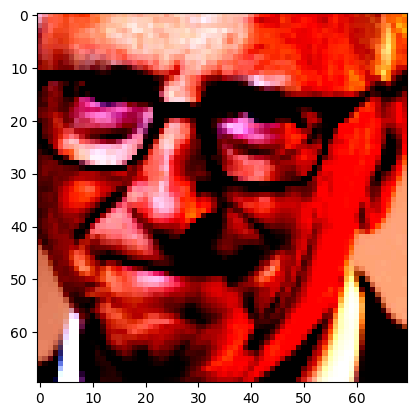

In [81]:
transform = transforms.Compose([
    transforms.CenterCrop(770),
    transforms.Resize(70),
    transforms.CenterCrop(70),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(45),
    #transforms.CenterCrop(70),
    transforms.ToTensor(),
    normalize
])

test = transform(image)
test = np.moveaxis(test.numpy(), 0, -1)
plt.imshow(test)

In [82]:
net.eval()
with torch.no_grad():
    tensor = transform(image)
    tensor = tensor.to(device)
    batch = torch.stack([tensor])
    output = net(batch)
    predicted = output.argmax().item()
print(output)
print(predicted)
print(train.classes[predicted])

tensor([[12.6723, -6.1482, -7.6407, -5.5328,  1.7181]], device='cuda:0')
0
bill_gates
